In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

[]


Found 21151 images belonging to 5 classes.
Found 4530 images belonging to 5 classes.
Found 4538 images belonging to 5 classes.

--- Distribución de Clases: DATASET COMPLETO (Total: 30219) ---
 Emoción  Conteo Total Proporción (%)
   angry          4953         16.39%
   happy          8989         29.75%
 neutral          6198         20.51%
     sad          6077         20.11%
surprise          4002         13.24%


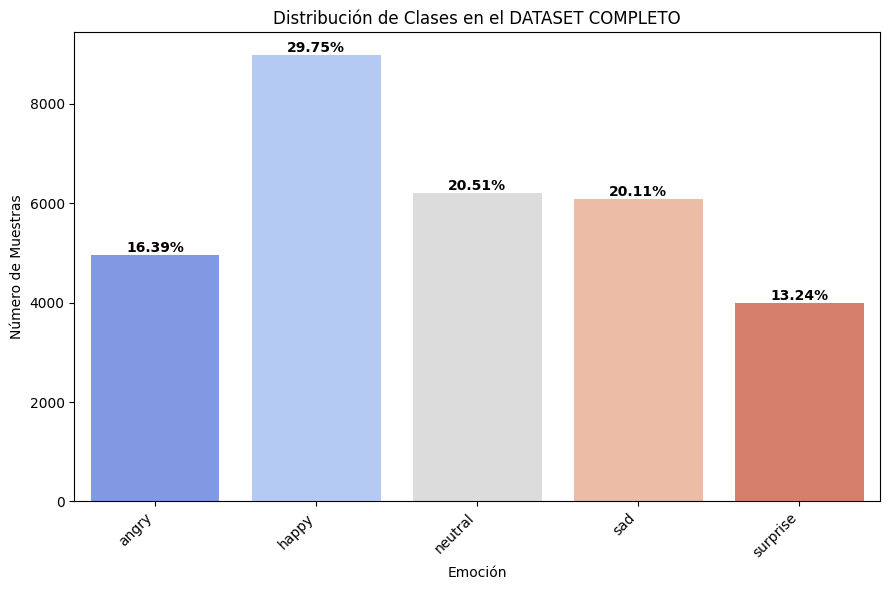

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'emotion_dataset/train'
val_dir = 'emotion_dataset/validation'
test_dir = 'emotion_dataset/test'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

def calculate_total_proportions(train_gen, val_gen, test_gen):
    train_counts = pd.Series(train_gen.classes).value_counts().sort_index()
    val_counts = pd.Series(val_gen.classes).value_counts().sort_index()
    test_counts = pd.Series(test_gen.classes).value_counts().sort_index()
    
    total_counts = train_counts.add(val_counts, fill_value=0).add(test_counts, fill_value=0).astype(int)
    total_samples = total_counts.sum()
    
    class_indices = train_gen.class_indices
    labels = {v: k for k, v in class_indices.items()}
    
    proportions = (total_counts / total_samples) * 100
    
    print(f"\n--- Distribución de Clases: DATASET COMPLETO (Total: {total_samples}) ---")
    
    df_proportions = pd.DataFrame({
        'Emoción': total_counts.index.map(labels),
        'Conteo Total': total_counts.values,
        'Proporción (%)': proportions.values.round(2)
    })
    
    df_display = df_proportions.copy()
    df_display['Proporción (%)'] = df_display['Proporción (%)'].astype(str) + '%'
    print(df_display.to_string(index=False))

    plt.figure(figsize=(9, 6))
    
    ax = sns.barplot(
        x=df_proportions['Emoción'], 
        y=df_proportions['Conteo Total'],
        hue=df_proportions['Emoción'], 
        palette='coolwarm',     
        legend=False
    )
    
    for i, p in enumerate(ax.patches):
        percentage = f'{df_proportions.iloc[i]["Proporción (%)"]:.2f}%'
        x = p.get_x() + p.get_width() / 2.
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10, weight='bold')

    plt.title('Distribución de Clases en el DATASET COMPLETO')
    plt.ylabel('Número de Muestras')
    plt.xlabel('Emoción')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

calculate_total_proportions(train_generator, validation_generator, test_generator)


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 emociones
])


c:\Users\mcash\anaconda3\envs\VC_MCH_P5_final\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    batch_size=64
)


Epoch 1/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.3085 - loss: 1.5782 - val_accuracy: 0.3430 - val_loss: 1.5777
Epoch 2/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.3975 - loss: 1.4058 - val_accuracy: 0.4448 - val_loss: 1.3363
Epoch 3/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.4480 - loss: 1.3081 - val_accuracy: 0.4698 - val_loss: 1.3625
Epoch 4/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.4776 - loss: 1.2501 - val_accuracy: 0.5510 - val_loss: 1.1342
Epoch 5/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.5091 - loss: 1.1946 - val_accuracy: 0.5709 - val_loss: 1.0681
Epoch 6/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.5313 - loss: 1.1553 - val_accuracy: 0.5625 - val_loss: 1.0977
Epoch 7/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.5504 - loss: 1.1215 - val_accuracy: 0.5581 - val_loss: 1.0955
Epoch 8/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.5590 - loss: 1.0987 - 

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Precisión en test: {test_acc*100:.2f}%')


# ----- GRÁFICA DE LOSS (train vs validation) -----
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolución de la Pérdida (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# ----- GRÁFICA DE ACCURACY (train vs validation) -----
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Evolución de Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6844 - loss: 0.8260
Precisión en test: 68.44%



Generando matriz de confusión PORCENTUAL para ENTRENAMIENTO (Train Set)...
331/331 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


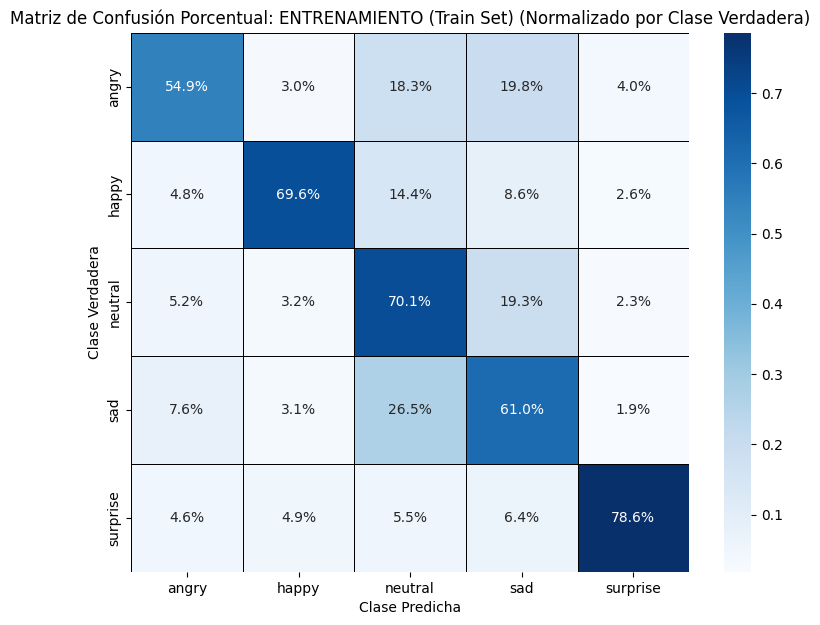


Generando matriz de confusión PORCENTUAL para VALIDACIÓN (Validation Set)...
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


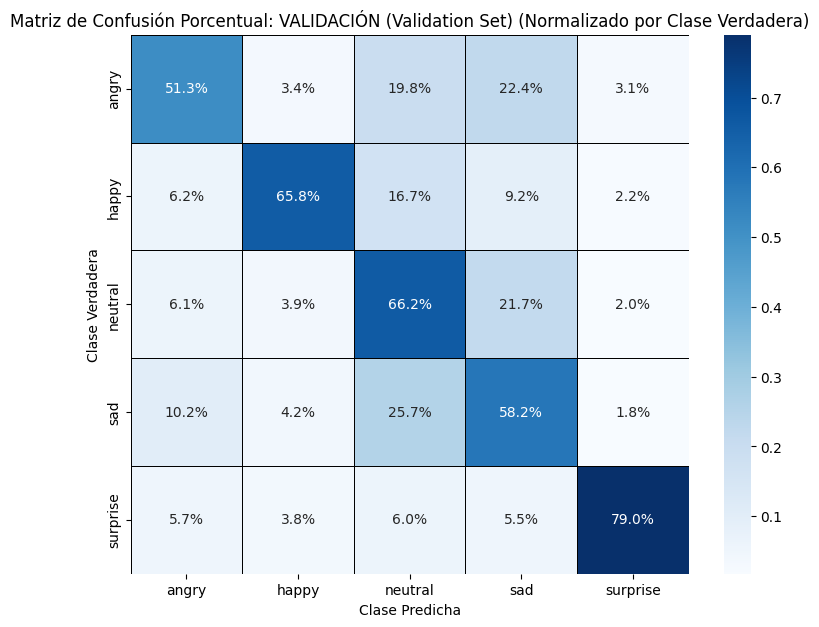


Generando matriz de confusión PORCENTUAL para TEST (Test Set)...
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


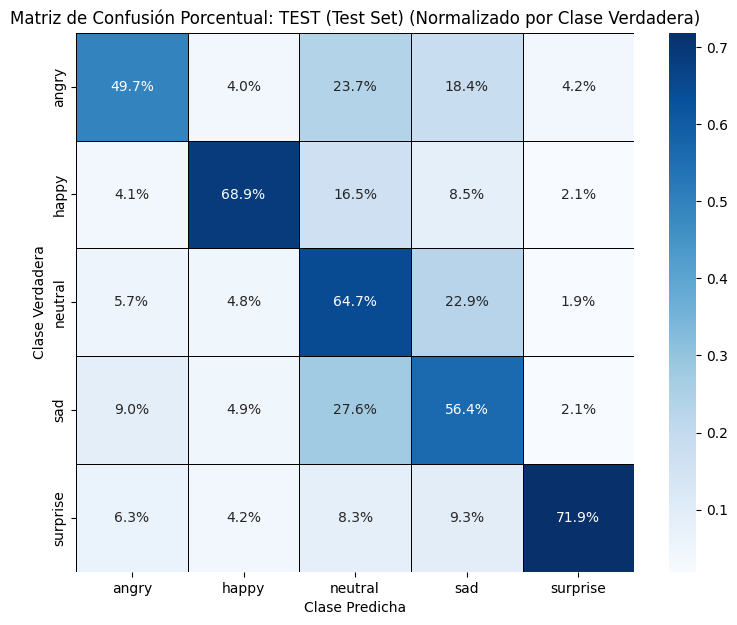

In [19]:
# =================================================================
# FUNCIÓN MODIFICADA PARA GENERAR MATRIZ PORCENTUAL
# =================================================================
def plot_confusion_matrix_percentage(ds_generator, title, model, labels):
    """Calcula, normaliza y plotea la matriz de confusión como porcentajes."""
    
    print(f"\nGenerando matriz de confusión PORCENTUAL para {title}...")
    
    # 1. Resetear el generador
    ds_generator.reset() 
    
    # 2. Obtener predicciones y clases verdaderas
    y_pred_probs = model.predict(ds_generator, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1) 
    y_true = ds_generator.classes 
    
    # 3. Calcular la matriz de confusión (conteo)
    cm = confusion_matrix(y_true, y_pred)
    
    # 4. NORMALIZACIÓN CRÍTICA: Dividir cada fila por la suma de la fila
    # Esto convierte los conteos en porcentajes (proporción de aciertos/errores por clase VERDADERA)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 5. Formatear para visualización
    # Usaremos 'sns.heatmap' para visualizar los porcentajes
    
    plt.figure(figsize=(9, 7))
    # Creamos etiquetas de texto para el heatmap (Ej: 95.2%)
    annot_labels = np.asarray([f'{val:.1f}%' for val in cm_normalized.flatten() * 100]).reshape(cm_normalized.shape)
    
    sns.heatmap(
        cm_normalized, 
        annot=annot_labels, 
        fmt="", # fmt vacío para usar las etiquetas personalizadas
        cmap="Blues",
        xticklabels=labels, 
        yticklabels=labels,
        cbar=True, # Mostrar barra de color (escala de 0.0 a 1.0)
        linewidths=.5, # Pequeñas líneas para separación
        linecolor='black'
    )
    plt.xlabel("Clase Predicha")
    plt.ylabel("Clase Verdadera")
    plt.title(f"Matriz de Confusión Porcentual: {title} (Normalizado por Clase Verdadera)")
    plt.show()

# =================================================================
# 6. GENERACIÓN DE MATRICES (USANDO LA NUEVA FUNCIÓN)
# =================================================================

# Nota: Asegúrate de que los generadores estén definidos (train_generator_pred, validation_generator, test_generator)

# Matriz de Confusión para TRAIN (Usando el generador sin shuffle)
plot_confusion_matrix_percentage(train_generator_pred, "ENTRENAMIENTO (Train Set)", model, labels)

# Matriz de Confusión para VALIDACIÓN
plot_confusion_matrix_percentage(validation_generator, "VALIDACIÓN (Validation Set)", model, labels)

# Matriz de Confusión para TEST (Prueba Final)
plot_confusion_matrix_percentage(test_generator, "TEST (Test Set)", model, labels)